In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV, GroupShuffleSplit
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor

In [2]:
# Read in the model parameters from the top of the data file
with open("../data/data.csv", "r") as f:
    params = dict([(param, float(val)) for (param, val) in [pair.split('=') for pair in f.readline().split(',')]])

In [3]:
# Read in the dataset from the CSV file
df = pd.read_csv("../data/data.csv", skiprows=1)

In [14]:
# Separate the dataset into the group, features, and target variable
grp = df["group"]
X = df.drop(columns=["group", "u"])
y = df["u"]

train_idx, test_idx = next(GroupShuffleSplit(test_size=0.2, random_state=0).split(X, y, grp))
X_train, y_train, grp_train = X.iloc[train_idx], y.iloc[train_idx], grp.iloc[train_idx]
X_test, y_test, grp_test = X.iloc[test_idx], y.iloc[test_idx], grp.iloc[test_idx]

In [16]:
param_grid = {"lasso__alpha": np.logspace(-12,-8,5),
              "pf__degree": range(1, 4)}

model = Pipeline([
    ("ss", StandardScaler()),
    ("pf", PolynomialFeatures()),
    ("lasso", Lasso(random_state=0))
])

gs = GridSearchCV(model, param_grid=param_grid, n_jobs=-1,
                  cv=GroupKFold(n_splits=5), verbose=99, return_train_score=True)

gs.fit(X_train, y_train, groups=grp_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('pf', PolynomialFeatures()),
                                       ('lasso', Lasso(random_state=0))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08]),
                         'pf__degree': range(1, 4)},
             return_train_score=True, verbose=99)

{'lasso__alpha': 1e-08, 'pf__degree': 3}
0.723127460693431


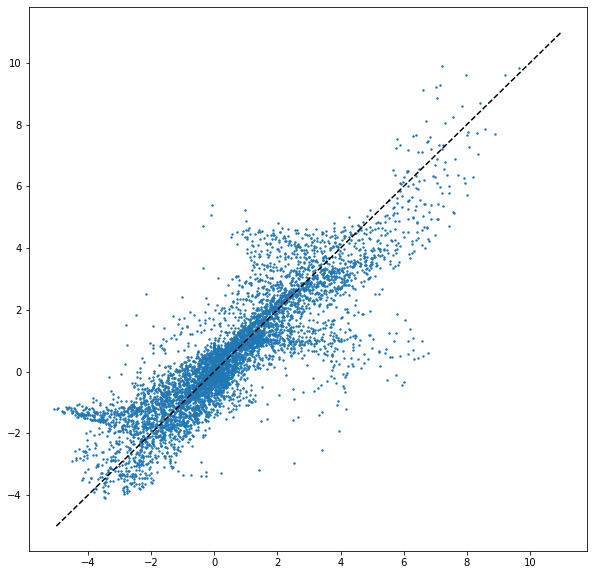

In [20]:
print(gs.best_params_)
print(gs.best_score_)

plt.figure(figsize=(10,10))
plt.scatter(y_test, gs.predict(X_test), s=2)
plt.plot([-5,11], [-5,11], "--k")

In [24]:
param_grid = {"xgb__reg_alpha": np.logspace(-3,1,10)}

model = Pipeline([
    ("xgb", XGBRegressor(max_depth=4, n_estimators=10000, reg_lambda=0, random_state=0))
])

gs = GridSearchCV(model, param_grid=param_grid,
                  cv=GroupKFold(n_splits=5), verbose=99, return_train_score=True)

fit_params = {"early_stopping_rounds":50,
              "eval_set":[[X_test, y_test]]}

gs.fit(X_train, y_train, groups=grp_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] xgb__reg_alpha=0.001 ............................................


KeyboardInterrupt: 

{'xgb__reg_alpha': 3.593813663804626}
0.9618109262221445


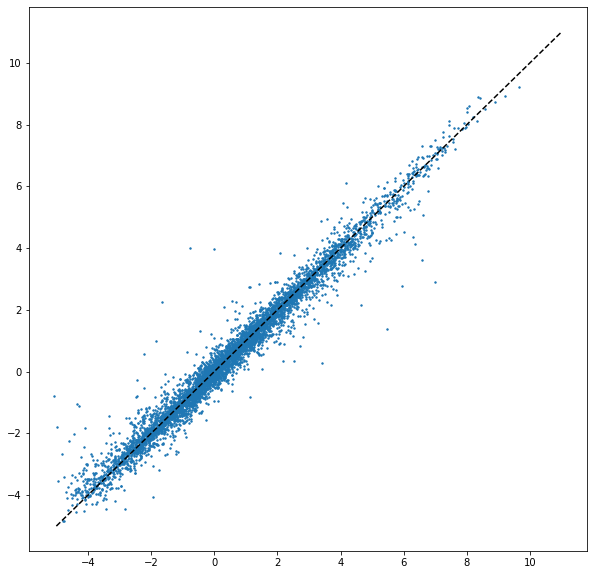

In [23]:
print(gs.best_params_)
print(gs.best_score_)

plt.figure(figsize=(10,10))
plt.scatter(y_test, gs.predict(X_test), s=2)
plt.plot([-5,11], [-5,11], "--k")